Welcome to our journey through the AutoML challenge! In this script, we'll be taking you through four essential sections that constitute our approach to this exciting competition.

Data Processing: Here, we'll dive into the intricacies of preparing our data for analysis. From cleaning and transforming raw data to structuring it for modeling, this stage sets the foundation for our entire AutoML pipeline.
Feature Selection: In this section, we'll explore how we identify and prioritize the most relevant features for our models. Through various techniques and algorithms, we aim to streamline our dataset and enhance the predictive power of our models.
Modeling: Here, we'll delve into the heart of our AutoML process – building and fine-tuning machine learning models. We'll explore different algorithms, hyperparameters, and evaluation metrics to optimize model performance.
Predicting: Finally, we'll demonstrate how our trained models are deployed to make predictions on new, unseen data. We'll discuss inference pipelines, model deployment strategies, and how we ensure the reliability and scalability of our predictions.
Join us as we navigate through these sections, leveraging the power of AutoML to tackle the challenges and unlock insights from our data!

**Installing all the required libraries**

In [ ]:
# %pip cache purge
%pip install --upgrade pip
%pip install --upgrade joblib==1.3.2
%pip install --upgrade scikit-learn
%pip install packaging
%pip install xgboost
%pip install openpyxl
%pip install --upgrade threadpoolctl
%pip install scikit-optimize
%pip install skrebate
%pip install tpot
%pip install mlxtend
%pip install scipy
%pip install h2o
%pip install optuna
%pip install optuna-integration
%pip install imblearn

# **1. Data Processing**

In [ ]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from skrebate import MultiSURF, TuRF
from tpot import TPOTClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

Functions created for the standard Datapreprocessing and imputation

In [ ]:
import pandas as pd
import numpy as np
import os
import random
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score , precision_recall_curve, roc_auc_score, precision_score, balanced_accuracy_score, recall_score
from imblearn.over_sampling import SMOTE
from scipy import stats
import numpy as np

def find_feature_type(df):
    feat_types = {}
    for col in df.columns:
        if (df[col].dtypes == object):
            feat_types[col] = 'categorical'
        elif (df[col].dtypes == float) or (df[col].dtypes == np.float64) or (df[col].dtypes == int) or (df[col].dtypes == np.int)  :
            feat_types[col] = 'numerical'
        else:
            feat_types[col] = 'other'
    return feat_types

def get_columns_with_missing_vals(df):
    list_cols = list(df.columns[df.isna().any()])
    # df[list_cols].apply(lambda x: print(x), axis=0)
    missing_val_details = {}
    for col in list_cols:
        miss_val_per = (len(df[col][df[col].isna()]))*100 / len(df[col])
        missing_val_details[col] = miss_val_per
    return missing_val_details

def encode_categorical_variables(df, categorical_cols, encode_nans = False, keep_categorical_cols = False):
    df_complete = df.copy()
    categorical_cols_encoded = []
    if (encode_nans == False):
        for col in categorical_cols:
            df_data = pd.DataFrame(df[col][~df[col].isna()])
            # df_data_arr = df_data.values[:, np.newaxis]
            # print("df_data " , df_data_arr)
            # print('nan vals =', df[col].shape[0] - df_data_arr.shape[0])
            enc = OneHotEncoder(sparse_output=False)
            arr_trans = enc.fit_transform(df_data)
            # print(arr_trans.shape, arr_trans)
            # feat_names = enc.feature_names_in_
            feat_names = enc.get_feature_names_out()
            categorical_cols_encoded = categorical_cols_encoded+list(feat_names)
            # print("feat_names : ", feat_names )
            df_trans = pd.DataFrame(arr_trans)
            df_trans.columns = feat_names
            df_trans.index = df_data.index
            # df_trans
            df_complete = pd.concat([df_complete,df_trans], axis=1, join='outer')
            # print(df_complete)
    else:
        enc = OneHotEncoder(sparse_output=False)
        arr_trans = enc.fit_transform(df)
        # print(arr_trans.shape, arr_trans)
        # feat_names = enc.feature_names_in_
        feat_names = enc.get_feature_names_out()
        categorical_cols_encoded = categorical_cols_encoded+list(feat_names)
        # print("feat_names : ", feat_names )
        df_trans = pd.DataFrame(arr_trans)
        df_trans.columns = feat_names
        df_trans.index = df.index
        # df_trans
        df_complete = pd.concat([df_complete,df_trans], axis=1, join='outer')

    if (keep_categorical_cols == False):
        for col in categorical_cols:
            df_complete.drop(col, axis=1, inplace=True)
    return df_complete,categorical_cols_encoded

def compute_missing_values(df, find_k = False, y_data = None):
    # df.replace(r'^\s*$', np.nan, regex=True, inplace=True)
    feat_types = find_feature_type(df)
    print(feat_types)
    missing_val_details = get_columns_with_missing_vals(df)
    print("missing_val_details : " , missing_val_details)
    cols_to_impute_with_KNN = []
    for col in missing_val_details.keys():
        # print(type(col), df[col].dtypes)
        print(col, missing_val_details[col], df[col].dtypes)
        # if (isinstance(df[col].dtypes, object)):
        if (feat_types[col] == 'categorical'):

            if (missing_val_details[col]<10):
                print("imputing with mode", df[col].mode()[0])
                df[col].fillna(df[col].mode()[0], inplace=True)
                df.loc[df[col].isnull(), col] = df[col].mode()[0]
            else:
                print("imputing with KNN")
                # impute_mod = KNNImputer()
                # impute_mod.fit_transform()
                # print(df[col].unique())
                # categories_consider = list(df[col].unique())
                # categories_consider.remove(np.nan)
                # print("categories_consider :", categories_consider)
                # cols_to_impute_with_KNN.append(col)

        elif (feat_types[col] == 'numerical')  :
            if (missing_val_details[col]<10):
                print("imputing with mean ", df[col].mean())
                df[col].fillna(df[col].mean(), inplace=True)
            else:
                print("imputing with KNN")
                cols_to_impute_with_KNN.append(col)
    print('categorical_cols : ', [k for k,v in feat_types.items() if v == 'categorical'])
    categorical_cols = [k for k,v in feat_types.items() if v == 'categorical']
    numerical_cols = [k for k,v in feat_types.items() if v == 'numerical']
    print("numerical_cols : ", numerical_cols)
    df_complete, categorical_cols_encoded = encode_categorical_variables(df, categorical_cols, encode_nans = False)
    # categorical_cols_encoded = df_complete.columns
    print("categorical_cols_encoded : ", categorical_cols_encoded)
    # df_complete = pd.concat([df_encoded, df[numerical_cols]], axis=1, join='outer')
    # for col1 in categorical_cols:
    #     df_complete.drop(col1 , axis=1, inplace=True)
    if find_k == False:
        knn_neighbors = int(np.ceil(np.sqrt(len(df_complete))/2) // 2 * 2 + 1)
        impute_mod = KNNImputer(n_neighbors=knn_neighbors)
        df_imputed = pd.DataFrame(impute_mod.fit_transform(df_complete))
        df_imputed.columns = df_complete.columns
        df_imputed.index = df_complete.index
    else:
        ### need to check if this is correct always coming as 11 =========
        knn_neighbors = int(np.ceil(np.sqrt(len(df_complete))/2) // 2 * 2 + 1)
        print("trying to find optimal K till 21 or ", knn_neighbors)
        results = []
        strategies = [str(i) for i in range(3, min(knn_neighbors, 22)+1, 2)]
        print(strategies)
        knn_neighbors_to_use = knn_neighbors
        max_acc = -np.nan
        for s in strategies:
            # create the modeling pipeline
            pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
            # evaluate the model
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(pipeline, df_complete, y_data.reindex(df_complete.index), scoring='accuracy', cv=cv, n_jobs=-1)
            if (np.mean(scores) > max_acc):
                print("entering in IF")
                knn_neighbors_to_use = int(s)
                max_acc = np.mean(scores)
            # store results
            results.append(scores)
            print('>%s %.3f (%.3f)' % (s, np.mean(scores), np.std(scores)))
        print("using knn_neighbors = ", knn_neighbors_to_use )
        impute_mod = KNNImputer(n_neighbors=knn_neighbors_to_use)
        df_imputed = pd.DataFrame(impute_mod.fit_transform(df_complete))
        df_imputed.columns = df_complete.columns
        df_imputed.index = df_complete.index
    df_imputed_raw = df_imputed.copy()

    df_imputed[categorical_cols_encoded] = df_imputed[categorical_cols_encoded].round()
    return df_imputed, numerical_cols, categorical_cols_encoded, df_imputed_raw

def plot_compare_percentage_distributions(df_original, df_imputed, cols_to_plot, target_col):
    cat_survival_distributions_imputed = {}
    cat_survival_distributions_original = {}
    print("inside compare percentage", df_original.shape, df_imputed.shape)
    for column in cols_to_plot:
        cat_survival_distribution_imputed = df_imputed.groupby([column, target_col]).size().unstack(fill_value=0)
        cat_survival_distribution_imputed = cat_survival_distribution_imputed.div(cat_survival_distribution_imputed.sum(axis=1), axis=0) * 100  # Convert counts to percentages
        cat_survival_distributions_imputed[column] = cat_survival_distribution_imputed
        cat_survival_distribution_original = df_original.groupby([column, target_col]).size().unstack(fill_value=0)
        cat_survival_distribution_original = cat_survival_distribution_original.div(cat_survival_distribution_original.sum(axis=1), axis=0) * 100  # Convert counts to percentages
        cat_survival_distributions_original[column] = cat_survival_distribution_original
    # print(cat_survival_distributions_imputed)
    # print(cat_survival_distributions_original)


    # Plot the distributions using a suitable visualization library (e.g., Matplotlib)
    for column in cat_survival_distributions_imputed.keys():

        # Plotting
        bar_width = 0.35  # Width of each bar
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

        distrib_org = cat_survival_distributions_original[column]
        distrib_imputed = cat_survival_distributions_imputed[column]
        distrib_org.plot(kind='bar', stacked=True, width = bar_width, label='original distribution',ax=axes[0])
        distrib_imputed.plot(kind='bar', stacked=True, width = bar_width, label='imputed distribution', ax=axes[1])

        axes[0].set_xlabel(column)
        axes[0].set_ylabel("Percentage")
        axes[0].set_title(f"Original Distribution of {column} (Percentage)")
        axes[0].legend(title='Survival Status')

        axes[1].set_xlabel(column)
        axes[1].set_ylabel("Percentage")
        axes[1].set_title(f"Imputed Distribution of {column} (Percentage)")
        axes[1].legend(title='Survival Status')
        plt.show()

def plot_compare_counts_distributions(df_original, df_imputed, cols_to_plot, target_col):
    cat_survival_distributions_imputed = {}
    cat_survival_distributions_original = {}
    print("inside compare count", df_original.shape, df_imputed.shape)

    for column in cols_to_plot:
        cat_survival_distribution_imputed = df_imputed.groupby([column, target_col]).size().unstack(fill_value=0)
        cat_survival_distribution_imputed = cat_survival_distribution_imputed #.div(cat_survival_distribution_imputed.sum(axis=1), axis=0) * 100  # Convert counts to percentages
        cat_survival_distributions_imputed[column] = cat_survival_distribution_imputed
        cat_survival_distribution_original = df_original.groupby([column, target_col]).size().unstack(fill_value=0)
        cat_survival_distribution_original = cat_survival_distribution_original #.div(cat_survival_distribution_original.sum(axis=1), axis=0) * 100  # Convert counts to percentages
        cat_survival_distributions_original[column] = cat_survival_distribution_original
    # print(cat_survival_distributions_imputed)
    # print(cat_survival_distributions_original)


    # Plot the distributions using a suitable visualization library (e.g., Matplotlib)
    for column in cat_survival_distributions_imputed.keys():

        # Plotting
        bar_width = 0.35  # Width of each bar
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

        distrib_org = cat_survival_distributions_original[column]
        distrib_imputed = cat_survival_distributions_imputed[column]
        distrib_org.plot(kind='bar', stacked=True, width = bar_width, label='original distribution',ax=axes[0])
        distrib_imputed.plot(kind='bar', stacked=True, width = bar_width, label='imputed distribution', ax=axes[1])

        axes[0].set_xlabel(column)
        axes[0].set_ylabel("Percentage")
        axes[0].set_title(f"Original Distribution of {column} (Percentage)")
        axes[0].legend(title='Survival Status')

        axes[1].set_xlabel(column)
        axes[1].set_ylabel("Percentage")
        axes[1].set_title(f"Imputed Distribution of {column} (Percentage)")
        axes[1].legend(title='Survival Status')
        plt.show()



def check_distribution_changes(df_original, df_sampled, alpha=0.05):
    # Original data and sampled data
    cols_changed_dist = []
    for col in df_original.columns:
        original_data = df_original[col]
        sampled_data = df_sampled[col]

        # Perform KS test
        ks_statistic, p_value = stats.ks_2samp(original_data, sampled_data)

        # # Print the results
        # print("KS Statistic:", ks_statistic)
        # print("P-value:", p_value)

        # Check the significance level (e.g., 0.05)
        if p_value < alpha:
            # print("Reject null hypothesis: Data distributions are different.")
            cols_changed_dist.append(col)
        # else:
            # print("Fail to reject null hypothesis: Data distributions are the same.")
    return cols_changed_dist

def print_confusion_matrix(cm, labels):
    for i, label in enumerate(labels):
        print("\t\tPredicted", label)
    for i, row in enumerate(cm):
        print("True", labels[i], "\t", row)

def check_performance(y_test, y_pred):
    print("accuracy_score : ", accuracy_score(y_test,y_pred ))
    print("balanced_accuracy : ", balanced_accuracy_score(y_test,y_pred ))
    print("f1_score : ", f1_score(y_test,y_pred ))
    print("precision : ", precision_score(y_test,y_pred))
    print("roc_auc_score : ", roc_auc_score(y_test,y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Calculate the true negative rate (specificity)
    tnr = tn / (tn + fp)
    print("true negative rate : ", tnr)
    tpr = recall_score(y_test, y_pred)
    print("true positive rate", tpr)

    # print("confusion_matrix : ", confusion_matrix(y_test,predictions_class))
    print_confusion_matrix(confusion_matrix(y_test,y_pred), [0,1])



Mounting the Google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading the file and dropping the columns with NAN values(Race)**

In [ ]:

import pandas as pd
import numpy as np
import os
import random
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold,RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score , precision_recall_curve, roc_auc_score, precision_score
from sklearn.feature_selection import RFECV, RFE
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
from sklearn.feature_selection import SelectFpr
from scipy.stats import skew
# Suppress all warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=DeprecationWarning)
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def load_and_clean_data(remove_rows = False):
    df_featMatrix =pd.read_csv("/content/drive/MyDrive/Copy of sc1_Phase1_GE_FeatureMatrix.tsv",sep="\t")
    # df_featMatrix.head()
    df_featMatrix = df_featMatrix.set_index(['PATIENTID'])
    print("df_featMatrix : ", df_featMatrix.shape)
    df_pheno =pd.read_csv("/content/sc1_Phase1_GE_Phenotype.tsv",sep="\t")
    df_pheno = df_pheno.set_index(['PATIENTID'])
    # df_pheno.head()
    print("df_pheno : ", df_pheno.shape)
    df_outcomes = pd.read_csv("/content/sc1_Phase1_GE_Outcome.tsv",sep="\t")
    print("df_outcomes : ", df_outcomes.shape)
    df_outcomes = df_outcomes.set_index(['PATIENTID'])
    # clean the data
    df_pheno_cleaned = df_pheno.copy()
    df_pheno_cleaned.replace('', np.nan, inplace=True)
    df_pheno_cleaned.replace(' ', np.nan, inplace=True)
    df_pheno_cleaned.drop(['RACE'], axis=1, inplace=True)
    # concat all the data
    df_complete = pd.concat([df_featMatrix, df_pheno_cleaned], axis=1)
    df_complete = pd.concat([df_complete, df_outcomes], axis=1)
    print(df_complete.columns)
    if (remove_rows == False):
    # not removing rows where all gender and WHO_GRADING both are nan's
        df_complete_new = df_complete.copy()
    else:
        # removing rows where all gender and WHO_GRADING both are nan's
        df_complete_new = df_complete[~((df_complete['SEX'].isna())& (df_complete['WHO_GRADING'].isna()))]
    target_col = 'SURVIVAL_STATUS'
    categorical_cols = df_pheno_cleaned.columns
    numerical_cols = df_featMatrix.columns
    # target_col, categorical_cols
    return df_complete_new, target_col, numerical_cols, categorical_cols

def impute_data(df_complete_new, target_col, numerical_cols, categorical_cols, categorical_seperate = False):
    X_df_complete_new = df_complete_new[[i for i in df_complete_new.columns if i!=target_col]]
    y_df_complete_new = df_complete_new[[i for i in df_complete_new.columns if i==target_col]]
    if (categorical_seperate == False):
        df_cleaned_data, numerical_cols, categorical_cols_encoded, df_cleaned_data_float = compute_missing_values(X_df_complete_new, find_k=False, y_data = y_df_complete_new)
        # check if there are any categorical cols that were not imputed correctly
        print(df_cleaned_data.shape)
        print(df_cleaned_data[categorical_cols_encoded].sum(axis=0))
        cols_to_correct = []
        for i in categorical_cols:
            cols_to_consider = [j for j in categorical_cols_encoded if i in j]
            print(i, df_cleaned_data[cols_to_consider].sum(axis=1).sum())
            test_df = df_cleaned_data[df_cleaned_data[cols_to_consider].sum(axis=1)!=1][cols_to_consider]
            print(test_df)
            if len(test_df>0):
                cols_to_correct.append(i)
        ## no need to clean the data
        print("cols to correct for rounding off : " , cols_to_correct)
        ## if we need to correct the entries found in the above cell
        if len(cols_to_correct)>0:
            for j in cols_to_correct:
                who_cols = [i for i in categorical_cols_encoded if j in i]
                print(who_cols)
                df_test = df_cleaned_data_float[df_cleaned_data[who_cols].sum(axis=1)==0][who_cols]
                # df_test.idxmax(axis = 1)
                df_test1 = df_test.eq(df_test.where(df_test != 0).max(1), axis=0).astype(int)
                df_test1.loc[df_test1.sum(axis=1)>1, who_cols] = 0
                df_cleaned_data.loc[df_cleaned_data[who_cols].sum(axis=1)==0,who_cols] = df_test1[who_cols]
        for i in categorical_cols:
            cols_to_consider = [j for j in categorical_cols_encoded if i in j]
            print("records missed after correction for : ", i, " are " , len(df_cleaned_data) - df_cleaned_data[cols_to_consider].sum(axis=1).sum())
        df_cleaned_data_y = pd.concat([df_cleaned_data, y_df_complete_new],axis=1)
        print(df_cleaned_data_y[categorical_cols_encoded].sum(axis=0))
        print(df_cleaned_data_y.shape)

    if (categorical_seperate == True):
        df_cleaned_data_num, numerical_cols, _, df_cleaned_data_num_float = compute_missing_values(X_df_complete_new[numerical_cols], find_k=False, y_data = y_df_complete_new)
        df_cleaned_data_cat, _, categorical_cols_encoded, df_cleaned_data_cat_float = compute_missing_values(X_df_complete_new[categorical_cols], find_k=False, y_data = y_df_complete_new)
        print("df_cleaned_data_num : ", df_cleaned_data_num.shape, df_cleaned_data_num.head())
        print("df_cleaned_data_cat : ", df_cleaned_data_cat.shape, df_cleaned_data_cat.head())
        print("df_cleaned_data_num_float : ", df_cleaned_data_num_float.shape, df_cleaned_data_num_float.head())
        print("df_cleaned_data_cat_float : ", df_cleaned_data_cat_float.shape, df_cleaned_data_cat_float.head())
        print(numerical_cols, categorical_cols, categorical_cols_encoded)

        df_cleaned_data = pd.concat([df_cleaned_data_num, df_cleaned_data_cat], axis=1)
        df_cleaned_data_float = pd.concat([df_cleaned_data_num_float, df_cleaned_data_cat_float], axis=1)
        print("df_cleaned_data : ", df_cleaned_data.shape, df_cleaned_data.head())
        print("df_cleaned_data_float : ", df_cleaned_data_float.shape, df_cleaned_data_float.head())

        # check if there are any categorical cols that were not imputed correctly
        print(df_cleaned_data.shape)
        print(df_cleaned_data[categorical_cols_encoded].sum(axis=0))
        cols_to_correct = []
        for i in categorical_cols:
            cols_to_consider = [j for j in categorical_cols_encoded if i in j]
            print(i, df_cleaned_data[cols_to_consider].sum(axis=1).sum())
            test_df = df_cleaned_data[df_cleaned_data[cols_to_consider].sum(axis=1)!=1][cols_to_consider]
            print(test_df)
            if len(test_df>0):
                cols_to_correct.append(i)
        ## no need to clean the data
        print("cols to correct for rounding off : " , cols_to_correct)
        ## if we need to correct the entries found in the above cell
        if len(cols_to_correct)>0:
            for j in cols_to_correct:
                who_cols = [i for i in categorical_cols_encoded if j in i]
                print(who_cols)
                df_test = df_cleaned_data_float[df_cleaned_data[who_cols].sum(axis=1)==0][who_cols]
                # df_test.idxmax(axis = 1)
                df_test1 = df_test.eq(df_test.where(df_test != 0).max(1), axis=0).astype(int)
                df_test1.loc[df_test1.sum(axis=1)>1, who_cols] = 0
                df_cleaned_data.loc[df_cleaned_data[who_cols].sum(axis=1)==0,who_cols] = df_test1[who_cols]
        for i in categorical_cols:
            cols_to_consider = [j for j in categorical_cols_encoded if i in j]
            print("records missed after correction for : ", i, " are " , len(df_cleaned_data) - df_cleaned_data[cols_to_consider].sum(axis=1).sum())
        df_cleaned_data_y = pd.concat([df_cleaned_data, y_df_complete_new],axis=1)
        print(df_cleaned_data_y.shape)
    return df_cleaned_data_y, numerical_cols, categorical_cols, categorical_cols_encoded

def pick_value(row):
    first_valid_value = row.dropna().iloc[0] if not row.isnull().all() else np.nan
    return first_valid_value


def reverse_one_hot_data(df, categorical_cols, categorical_cols_encoded):

    df_cleaned_data_reversed = df.copy()
    for i in categorical_cols:
        df_test1= df_cleaned_data_reversed[[j for j in df_cleaned_data_reversed.columns if i in j]]
        for col in df_test1.columns:
            df_test1[col].replace(1, col.split("_")[-1] , inplace=True)
        df_test1.replace(0, np.nan, inplace=True)
        print(df_test1)
        values = df_test1.apply(pick_value, axis=1)
        print(values)
        df_cleaned_data_reversed[i] = values
    df_cleaned_data_reversed = df_cleaned_data_reversed.drop(categorical_cols_encoded, axis=1)
    return df_cleaned_data_reversed


def feat_sel_cov_skew(df,  target_col, numerical_cols, categorical_cols, categorical_cols_encoded, only_numeric=True, var_quant_thresh = 0.75):
    '''
    only numeric = False will use categotical features as well
    var_quant_thresh : quanatile to use for thresholding 0 - 1 float
    '''

    df_features = df.drop(columns=[target_col])
    df_features = df_features.drop(columns=categorical_cols_encoded)
    df_target = df[target_col]
    # # Calculate covariance between each feature and the target
    covariances = df_features.apply(lambda x: np.cov(x, df_target)[0][1])
    # # Calculate skewness for each feature
    skewness = df_features.apply(lambda x: skew(x))
    # # Combine covariance and skewness into a DataFrame

    feature_stats = pd.DataFrame({'Covariance': covariances, 'Skewness': skewness})

    # # Example selection criteria: select features with high absolute covariance and high absolute skewness
    # # Note: You'll need to define what "high" means in your context

    high_covariance_threshold = feature_stats['Covariance'].abs().quantile(var_quant_thresh)  # Example threshold: 75th percentile
    #
    high_skewness_threshold = feature_stats['Skewness'].abs().quantile(var_quant_thresh)  # Example threshold: 75th percentile

    selected_features = feature_stats[(feature_stats['Covariance'].abs() >= high_covariance_threshold) &
                                    (feature_stats['Skewness'].abs() >= high_skewness_threshold)].index.tolist()

    # # Resulting selected features based on custom CovSkew method

    print("No of selected Features based on Covariance and Skewness:", len(selected_features))

    if only_numeric == False:
        selected_features = list(selected_features) + list(categorical_cols_encoded)
    else:
        selected_features = list(selected_features)
    return selected_features

def feat_sel_fpr(df,  target_col, numerical_cols, categorical_cols, categorical_cols_encoded, only_numeric=True, alpha_val = 0.05):
    '''
    only numeric = False will use categotical features as well
    var_quant_thresh : quanatile to use for thresholding 0 - 1 float
    '''
    df_target = df[target_col]
    '''
    if (only_numeric == True):
        df_features = df.drop(columns=[target_col])
        df_features = df_features.drop(columns=categorical_cols_encoded)
    else:
        df_features = df.drop(columns=[target_col])
    '''
    feat_sel_fpr = SelectFpr(alpha=alpha_val)
    df_features = df.drop(columns=[target_col])
    df_features = df_features.drop(columns=categorical_cols_encoded)
    feat_sel_fpr.fit(df_features, df_target)
    # feat_sel_var.feature_names_in_[feat_sel_var.support_]
    selected_feat_fpr = list(feat_sel_fpr.get_feature_names_out())
    if (only_numeric == False):
        selected_feat_fpr = list(selected_feat_fpr) + list(categorical_cols_encoded)

    print("No of selected Features based on Covariance and Skewness:", len(selected_feat_fpr)) #, selected_feat_fpr)

    return selected_feat_fpr

def split_data_and_SMOTE(df, selected_features,  target_col, numerical_cols, categorical_cols, categorical_cols_encoded,test_split_size = 0.1, round_off_SMOTE =True, seed = 110):
    ## train test split and handling class imbalance on selected features
    df_selected_feat_data = df[selected_features]
    df_target = df[target_col]
    # ip_cols = [i for i in df_selected_feat_data.columns if i != target_col]
    print("df_selected_feat_data : ", df_selected_feat_data.shape)
    print("df_target : ", df_target.shape)

    # df_cleaned_data_y = pd.concat([df_cleaned_data, df_outcomes], axis=1, join='outer')
    X_train, X_test, y_train, y_test = train_test_split(df_selected_feat_data, df_target, test_size=test_split_size, random_state=seed, stratify=df_target.values)
    train_pat_id = X_train.index
    val_pat_id = X_test.index

    oversample = SMOTE()
    X_train_samp, y_train_samp = oversample.fit_resample(X_train, y_train)

    print(
        "Using %d samples for training and %d for validation"
        % (len(X_train), len(X_test))
    )
    print(
        "Using %d samples for training after sampling and %d for validation"
        % (len(X_train_samp), len(X_test))
    )
    print("label distribution : " , y_train.sum()*100/len(y_train), y_test.sum()*100/len(y_test))
    print("label distribution after samping : " , y_train_samp.sum()*100/len(y_train_samp), y_test.sum()*100/len(y_test))

    categorical_feat_used = list(set(categorical_cols_encoded).intersection(set(selected_features)))
    print("categorical_feat_used : ", categorical_feat_used)
    if (round_off_SMOTE == True):
        print(categorical_feat_used, X_train_samp[categorical_feat_used].sum())
        for j in categorical_cols:
            who_cols = [i for i in categorical_feat_used if j in i]
            # print(who_cols)
            if (len(who_cols)>0):
                df_test = X_train_samp[X_train_samp[who_cols].sum(axis=1)==0][who_cols]
                # df_test.idxmax(axis = 1)
                df_test1 = df_test.eq(df_test.where(df_test != 0).max(1), axis=0).astype(int)
                df_test1.loc[df_test1.sum(axis=1)>1, who_cols] = 0
                X_train_samp.loc[X_train_samp[who_cols].sum(axis=1)==0,who_cols] = df_test1[who_cols]
        cols_changed_dist = check_distribution_changes(X_train, X_train_samp)
        print(len(cols_changed_dist)) # check if these are the ones that are getting used more in prediction zero
        # print([i for i in cols_changed_dist if "_" in i])
    else:
        cols_changed_dist = check_distribution_changes(X_train, X_train_samp)
        print(len(cols_changed_dist))

    '''
    categorical_feat_used = list(set(categorical_cols_encoded).intersection(set(selected_features)))
    print("categorical_feat_used : ", categorical_feat_used)
    if (round_off_SMOTE == True):
        print(X_train_samp[categorical_feat_used].sum())
        ## this is not looking correct since after selecting features if we do SMOTE not all categories are going to get selected
        cols_to_correct_samp = []
        for i in categorical_cols:
            cols_to_consider = [j for j in categorical_feat_used if i in j]
            if len(cols_to_consider)== 0:
                continue
            test_df = X_train_samp[X_train_samp[cols_to_consider].sum(axis=1)!=1][cols_to_consider]
            print(test_df)
            print("sum : ", X_train_samp[cols_to_consider].sum(axis=0).sum())
            if len(test_df>0):
                cols_to_correct_samp.append(i)
        print("cols_to_correct_samp : ", cols_to_correct_samp)
        ## no need to clean the data
        ## if we need to correct the entries found in the above cell, who_grading is corrected
        if len(cols_to_correct_samp)>0:
            for j in cols_to_correct_samp:
                who_cols = [i for i in categorical_feat_used if j in i]
                # print(who_cols)
                df_test = X_train_samp[X_train_samp[who_cols].sum(axis=1)==0][who_cols]
                # df_test.idxmax(axis = 1)
                df_test1 = df_test.eq(df_test.where(df_test != 0).max(1), axis=0).astype(int)
                df_test1.loc[df_test1.sum(axis=1)>1, who_cols] = 0
                X_train_samp.loc[X_train_samp[who_cols].sum(axis=1)==0,who_cols] = df_test1[who_cols]

        for i in categorical_cols:
            print(i)
            cols_to_consider = [j for j in categorical_feat_used if i in j]
            if len(cols_to_consider)== 0:
                continue
            test_df = X_train_samp[X_train_samp[cols_to_consider].sum(axis=1)!=1][cols_to_consider]
            print("sum : ", X_train_samp[cols_to_consider].sum(axis=0).sum())
            print("cases missed = " , len(X_train_samp) - X_train_samp[cols_to_consider].sum(axis=0).sum())

        cols_changed_dist = check_distribution_changes(X_train, X_train_samp)
        print(len(cols_changed_dist)) # check if these are the ones that are getting used more in prediction zero
        # print([i for i in cols_changed_dist if "_" in i])
    '''

    return (X_train_samp, y_train_samp), (X_test, y_test), (X_train, y_train), cols_changed_dist

def SMOTE_on_selected_features(X_train, y_train, selected_features,  target_col, numerical_cols, categorical_cols, categorical_cols_encoded,test_split_size = 0.1, round_off_SMOTE =True, seed = 110):
    X_train_subset = X_train.copy()
    X_train_subset = X_train[selected_features]
    y_train_subset = y_train.copy()
    oversample = SMOTE()
    X_train_samp, y_train_samp = oversample.fit_resample(X_train_subset, y_train_subset)


    print("label distribution after samping : " , y_train_samp.sum()*100/len(y_train_samp))

    categorical_feat_used = list(set(categorical_cols_encoded).intersection(set(selected_features)))
    print("categorical_feat_used : ", categorical_feat_used)
    if (round_off_SMOTE == True):
        print(categorical_feat_used, X_train_samp[categorical_feat_used].sum())
        for j in categorical_cols:
            who_cols = [i for i in categorical_feat_used if j in i]
            # print(who_cols)
            if (len(who_cols)>0):
                df_test = X_train_samp[X_train_samp[who_cols].sum(axis=1)==0][who_cols]
                # df_test.idxmax(axis = 1)
                df_test1 = df_test.eq(df_test.where(df_test != 0).max(1), axis=0).astype(int)
                df_test1.loc[df_test1.sum(axis=1)>1, who_cols] = 0
                X_train_samp.loc[X_train_samp[who_cols].sum(axis=1)==0,who_cols] = df_test1[who_cols]
        cols_changed_dist = check_distribution_changes(X_train_subset, X_train_samp)
        print(len(cols_changed_dist)) # check if these are the ones that are getting used more in prediction zero
        # print([i for i in cols_changed_dist if "_" in i])
    else:
        cols_changed_dist = check_distribution_changes(X_train_subset, X_train_samp)
        print(len(cols_changed_dist))

    return (X_train_samp, y_train_samp), (X_train_subset, y_train_subset), cols_changed_dist


def check_XGB_model(X_train_samp, y_train_samp, X_test, y_test, scale_pos_weight=None, scoring_metric = 'f1'):
        if scale_pos_weight is None:
                search_params = {
                        'n_estimators': Integer(50, 400),
                        'max_depth': Integer(3, 4),
                        # 'learning_rate' :Real(10**-3, 10**-1, "log-uniform"),
                        'scale_pos_weight' : Real(0.05, 1),
                        # 'subsample':Real(0.1, 1)
                        # 'early_stopping_rounds' : Integer(10, 11)
                        }
                est = XGBClassifier()
        else:
                search_params = {
                        'n_estimators': Integer(50, 400),
                        'max_depth': Integer(3, 4),
                        # 'learning_rate' :Real(10**-3, 10**-1, "log-uniform"),
                        # 'scale_pos_weight' : Real(0.05, 1),
                        # 'subsample':Real(0.1, 1)
                        # 'early_stopping_rounds' : Integer(10, 11)
                        }
                est = XGBClassifier(scale_pos_weight = scale_pos_weight)
        print("running XGB on n_samples x n_features = ", X_train_samp.shape)
        gs = BayesSearchCV(est, search_params, cv=10, verbose=3, scoring = scoring_metric, n_jobs=-1) #scoring = 'f1', n_jobs=-1)
        gs.fit(X_train_samp, y_train_samp)
        # gs.fit(X_train_samp[selected_feat_from_model], y_train_samp)
        predictions_class = gs.best_estimator_.predict(X_test)
        # pd.DataFrame(predictions_class).value_counts()
        print("best params : ", gs.best_params_)
        # est.fit(X_train_sel_feat_samp, y_train_sel_feat_samp)
        # predictions_class = est.predict(X_test[selected_feat_from_model])
        check_performance(y_test, predictions_class)
        # predicted_prob = gs.best_estimator_.predict_proba(X_test)
        # predicted_prob
        return gs.best_estimator_, gs.best_params_

# %%





Import all the traial automl and ml libraries


In [ ]:
import pandas as pd
import numpy as np
import os
import random
import joblib
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold,RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score , precision_recall_curve, roc_auc_score, precision_score
from sklearn.feature_selection import RFECV, RFE
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category=DeprecationWarning)
from skopt import BayesSearchCV
from skopt.space import Real, Integer


In this notebook , all the categorical variables are imputed by KNN, either using or without using numerical fetures (also doing some preprocessing like GBM and grade I can't come together, etc.). Not removing any records even if SEX and WHO_GRADING both has nans.
Did feature selection with different methods and checked XGBoost best iteration with ensemble (scale_pos_weight always set to handle imbalance)
After SMOTE,categorical variables are rounded off and distribution check is done

In [ ]:
impute_categorical_separately = False
test_split_size = 0.1
use_SMOTE_data = False
py_train_size_SMOTE = 1.0
py_train_size_wo_SMOTE = 1.0
use_test_data = False #
ensemble_diff_models = True ## if True takes all SVM, lr, nb, rf etc models. If false takes rf and xgboost with different class_weights
metric_opt = 'balanced_accuracy' # accuracy, auc, f1, f1_weighted, precision

In [ ]:
seed_val = 77
random.seed(seed_val)
np.random.seed(seed_val)
# tf.random.set_seed(seed_val)

In [ ]:
df_complete_new, target_col, numerical_cols, categorical_cols = load_and_clean_data()

df_featMatrix :  (377, 19335)
df_pheno :  (377, 4)
df_outcomes :  (377, 2)
Index(['A1BG', 'A1BG.AS1', 'A1CF', 'A2M', 'A2M.AS1', 'A2ML1', 'A4GALT',
       'A4GNT', 'AA06', 'AAAS',
       ...
       'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3', 'SEX',
       'WHO_GRADING', 'CANCER_TYPE', 'SURVIVAL_STATUS'],
      dtype='object', length=19339)


Making Impute function however it doesn't improve the result so we made it False

In [ ]:
if impute_categorical_separately == False:
    df_cleaned_data_y, numerical_cols, categorical_cols, categorical_cols_encoded = impute_data(df_complete_new, target_col, numerical_cols, categorical_cols, categorical_seperate = impute_categorical_separately)
    df_cleaned_data_y_reversed = reverse_one_hot_data(df_cleaned_data_y, categorical_cols, categorical_cols_encoded)
    df_cleaned_data_y_reversed[[target_col,'CANCER_TYPE', 'WHO_GRADING']].value_counts()
else:
    df_cleaned_data_y, numerical_cols, categorical_cols, categorical_cols_encoded = impute_data(df_complete_new, target_col, numerical_cols, categorical_cols, categorical_seperate = impute_categorical_separately)
    df_cleaned_data_y_reversed = reverse_one_hot_data(df_cleaned_data_y, categorical_cols, categorical_cols_encoded)
    df_cleaned_data_y_reversed[[target_col,'CANCER_TYPE', 'WHO_GRADING']].value_counts()

**check all the distribution for data understanding pupose**

inside compare percentage (377, 19339) (377, 19339)


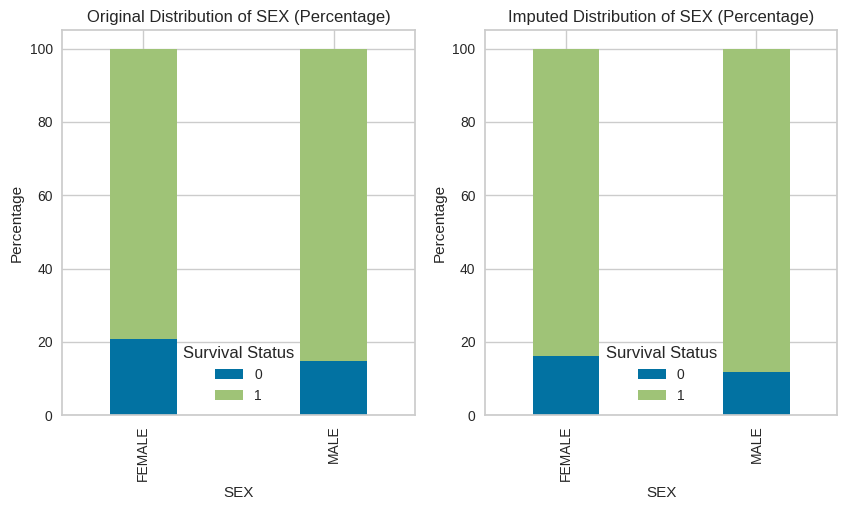

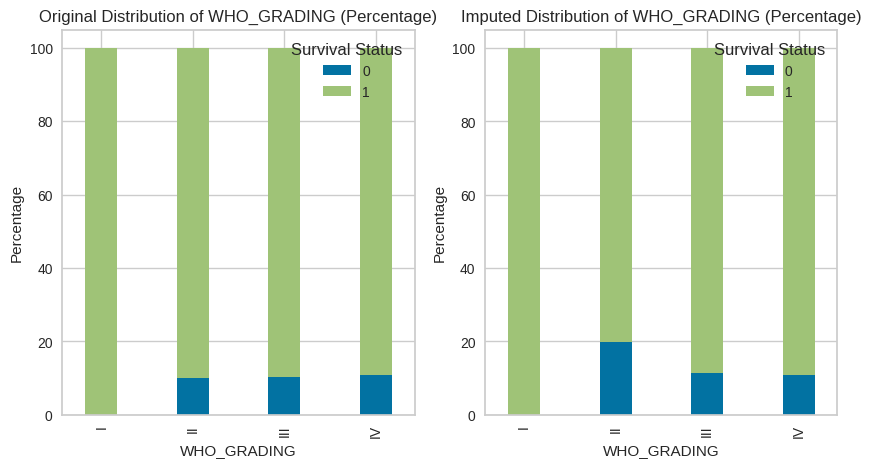

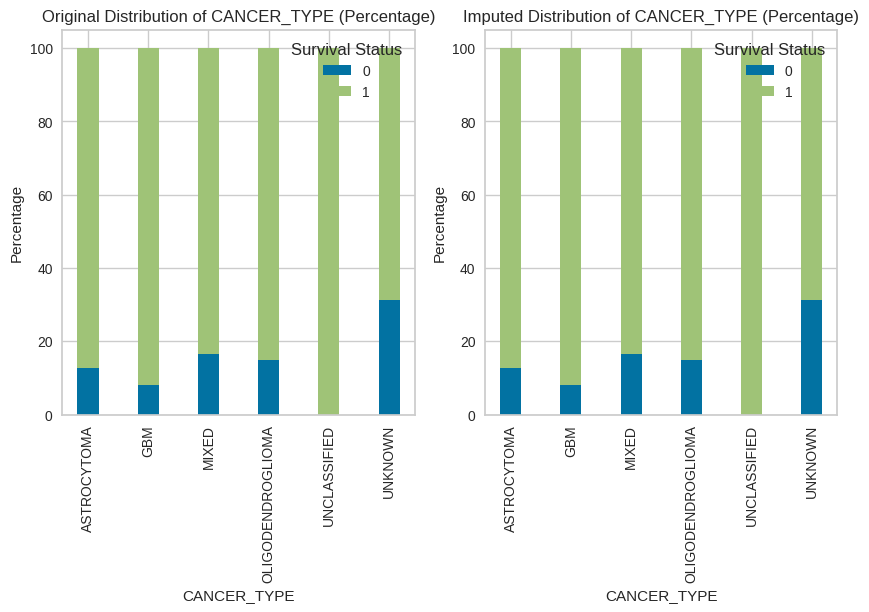

In [ ]:
# Perform aggregation and count for each categorical column
plot_compare_percentage_distributions(df_original = df_complete_new,
                                       df_imputed = df_cleaned_data_y_reversed, cols_to_plot = categorical_cols,
                                       target_col= target_col)



inside compare count (377, 19339) (377, 19339)


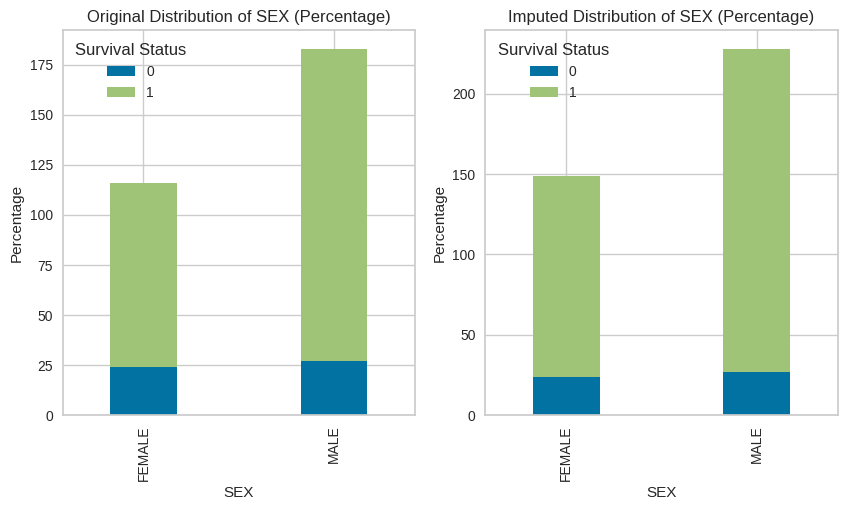

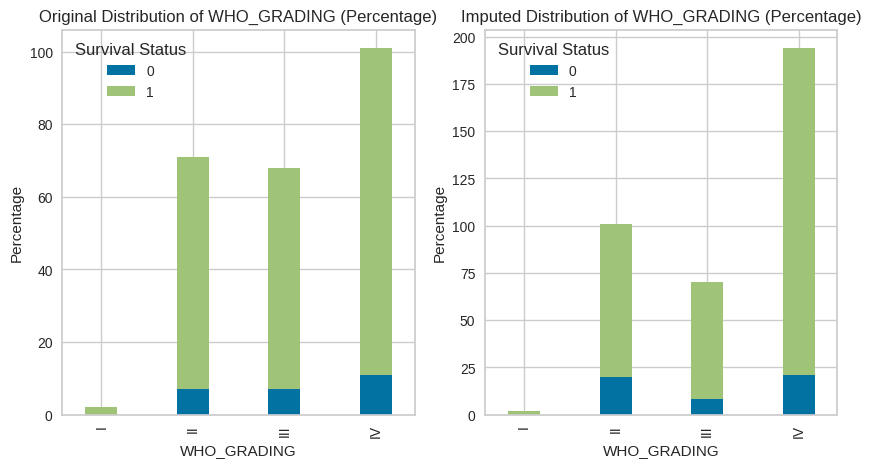

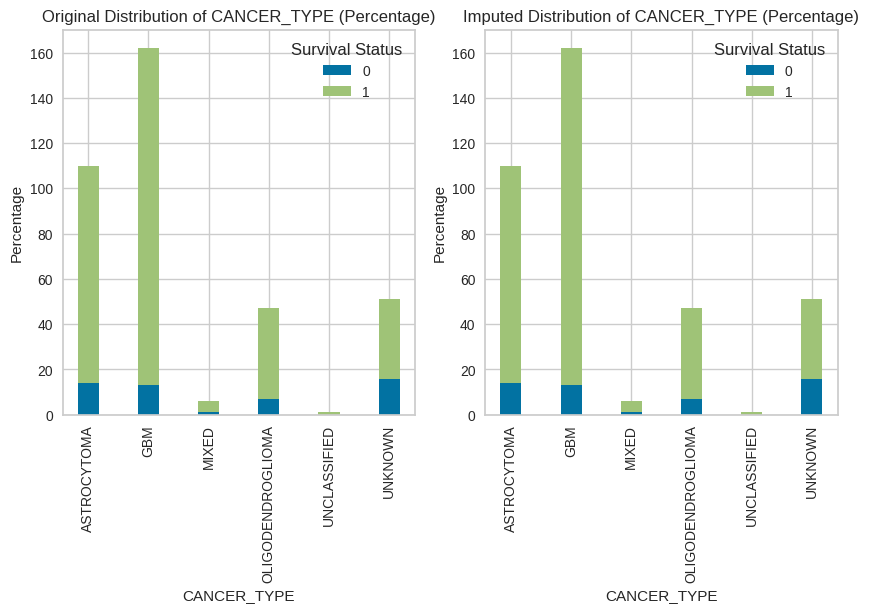

In [ ]:
# Perform aggregation and count for each categorical column
plot_compare_counts_distributions(df_original = df_complete_new,
                                       df_imputed = df_cleaned_data_y_reversed, cols_to_plot = categorical_cols,
                                       target_col= target_col)



# **2. Feature Selection**

### Conisdering all the Data for Train and Defining the N folds in the Algorithm itself

**Defning the train data as total dataframe as the cross validation is applied in the Algorithms itself **

In [ ]:
total_columns=list(categorical_cols_encoded)+numerical_cols
X_train,y_train=df_cleaned_data_y[total_columns], df_cleaned_data_y[target_col]

## **Feature selection method :Traditional**

### This section Contains Traditional Feature selection method outside the scope of AutoML.

In [ ]:

## Method -1 Mann-Whitney U test

from scipy.stats import mannwhitneyu
# Perform Wilcoxon test (Mann-Whitney U test) for each feature on the training set
n_features = 20
# def mann_whitney_feat_select(X_train, y_train, threshold=1e-5):
p_values = {}
for column in X_train.columns:
    stat, p = mannwhitneyu(
        X_train.loc[y_train == 0, column],
        X_train.loc[y_train == 1, column]
    )
    p_values[column] = p

# Filter features that meet the stringent p-value condition
stringent_p_value = 5e-4
significant_features_mann_whitney = [feature for feature, p_value in p_values.items() if p_value <= stringent_p_value]
len(significant_features_mann_whitney)



###Method -2 Skew Covarinace feature selection


from scipy.stats import skew

df_features = X_train.copy()
df_target = y_train.copy()
# # Calculate covariance between each feature and the target
covariances = df_features.apply(lambda x: np.cov(x, df_target)[0][1])
# # Calculate skewness for each feature
skewness = df_features.apply(lambda x: skew(x))
# # Combine covariance and skewness into a DataFrame

feature_stats = pd.DataFrame({'Covariance': covariances, 'Skewness': skewness})
var_quant_thresh = 0.85
high_covariance_threshold = feature_stats['Covariance'].abs().quantile(var_quant_thresh)  # Example threshold: 75th percentile
#
print(high_covariance_threshold)
high_skewness_threshold = feature_stats['Skewness'].abs().quantile(var_quant_thresh)  # Example threshold: 75th percentile

significant_features_cov_skew = feature_stats[(feature_stats['Covariance'].abs() >= high_covariance_threshold) &
                                (feature_stats['Skewness'].abs() >= high_skewness_threshold)].index.tolist()

# # Resulting selected features based on custom CovSkew method
print(high_covariance_threshold ,high_covariance_threshold )

# print("No of selected Features based on Covariance and Skewness:", len(significant_features_cov_skew))
# selected_feat_cov = selected_features.copy()
len(significant_features_cov_skew)



### Method 3-- Multisurf-turf
from skrebate import MultiSURF, TuRF
# MultiSURF on the training data
multisurf = MultiSURF(n_jobs=-1)
multisurf.fit(X_train.values, y_train.values)
feature_importances = multisurf.feature_importances_
feature_ranks = np.argsort(feature_importances)[::-1]
top_n_features = int(0.2 * X_train.shape[1])  # Adjust this to select the percentage of features
selected_features = feature_ranks[:top_n_features]
X_train_filtered = X_train.iloc[:, selected_features]

# Apply TuRF on the features selected by MultiSURF
headers = list(X_train_filtered)
fs = TuRF(core_algorithm="ReliefF", n_features_to_select=150, pct=0.2, verbose=True)
fs.fit(X_train_filtered.values, y_train.values, headers)

sorted_features = sorted(zip(X_train_filtered.columns, fs.feature_importances_), key=lambda x: x[1], reverse=True)
ranked_features = [(rank+1, feature_name, feature_score) for rank, (feature_name, feature_score) in enumerate(sorted_features)]

# Print ranked features
for rank, feature_name, feature_score in ranked_features:
    print(f"Rank {rank}: {feature_name} \t Score: {feature_score}")

# Create a DataFrame from the ranked features
ranked_features_df = pd.DataFrame(ranked_features, columns=['Rank', 'Feature Name', 'Feature Score'])




rank_threshold = 201 # Adjust this for the number of top features to select
significant_features_multisurf = [name for rank, (name, score) in enumerate(sorted_features) if rank < rank_threshold]
len(significant_features_multisurf)

###Method 4:Select FPR Feature selection----

## selectFPR
from sklearn.feature_selection import SelectFpr
SelectFpr_obj = SelectFpr(alpha=1e-4)
SelectFpr_obj.fit(X_train, y_train)
significant_features_selectFPR = SelectFpr_obj.get_feature_names_out()
len(significant_features_selectFPR) #, selected_feat_cov


In [ ]:
# Combining all features
unique_feats =  list(set(list(significant_features_selectFPR) + list(significant_features_multisurf) + list(significant_features_cov_skew) + list(significant_features_mann_whitney)))

In [ ]:
#Unique features consolidation

df_ip = pd.DataFrame(unique_feats)
df_ip = df_ip.rename({0:'feature'}, axis=1)
# print(df_ip)
df_ip['multisurf_present'] = 0
df_ip['cov_skew_present'] = 0
df_ip['selectFPR_present'] = 0
df_ip['mann_whitney_present'] = 0
df_features_rank = pd.DataFrame()
for i, row in df_ip.iterrows():
  if row['feature'] in significant_features_mann_whitney:
    row['mann_whitney_present'] = row['mann_whitney_present'] + 1
  if row['feature'] in significant_features_cov_skew:
    row['cov_skew_present'] = row['cov_skew_present'] + 1
  if row['feature'] in significant_features_multisurf:
    row['multisurf_present'] = row['multisurf_present'] + 1
  if row['feature'] in significant_features_selectFPR:
    row['selectFPR_present'] = row['selectFPR_present'] + 1
  df_features_rank = pd.concat([df_features_rank, pd.DataFrame(row).transpose()])
df_features_rank


## ranking the Features based on common methods
features_rank_greater_3 = list(df_features_rank[df_features_rank.sum(axis=1)>=3].index)
features_rank_greater_2 = list(df_features_rank[df_features_rank.sum(axis=1)>=2].index)
features_rank_greater_1 = list(df_features_rank[df_features_rank.sum(axis=1)>=1].index)

len(features_rank_greater_3), len(features_rank_greater_2), len(features_rank_greater_1)

### Running the Models in Automl for testing the Inititial accuracy for the Selected features. (Max model:5)

In [ ]:
### Training all model at once with Above setup
import h2o
from h2o.automl import H2OAutoML
from h2o.frame import H2OFrame
# Initialize the H2O cluster
h2o.init()
# Defining the train data if with any features
X_train_features = X_train[features_rank_greater_3]
X_train_final = pd.concat([X_train_features,y_train],axis=1)
# Convert pandas DataFrame to H2OFrame
Train_df = H2OFrame(X_train_final)
## Defining the Categorical Value for as Factor
Train_df["SURVIVAL_STATUS"]=Train_df["SURVIVAL_STATUS"].asfactor()
# Defnining the Target Columns
target = "SURVIVAL_STATUS"
train_cols = [x for x in Train_df.columns if x != target]


### running the models for features
aml_feat = H2OAutoML(max_models=25,seed=123,nfolds=10)
aml_feat.train(x=train_cols, y=target, training_frame=Train_df)
# aml.train(x=train_cols, y=target, training_frame=Train_df)
# View the AutoML Leaderboard
# lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)
# Get leaderboard with all possible columns
lb = h2o.automl.get_leaderboard(aml_feat, extra_columns = "ALL")
lb


# Shutdown H2O cluster
h2o.cluster().shutdown()



## ***Feature selection models Automl ***

### Set up a H20 Environment for running the Basic model for getting the Features importance

In [ ]:
### Training all model at once with Above setup
import h2o
from h2o.automl import H2OAutoML
from h2o.frame import H2OFrame
# Initialize the H2O cluster
h2o.init()
# Defining the train data if with any features
X_train_features = X_train
X_train_final = pd.concat([X_train_features,y_train],axis=1)
# Convert pandas DataFrame to H2OFrame
Train_df = H2OFrame(X_train_final)
## Defining the Categorical Value for as Factor
Train_df["SURVIVAL_STATUS"]=Train_df["SURVIVAL_STATUS"].asfactor()
# Defnining the Target Columns
target = "SURVIVAL_STATUS"
train_cols = [x for x in Train_df.columns if x != target]

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp6hyw_272
  JVM stdout: /tmp/tmp6hyw_272/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp6hyw_272/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_unknownUser_gkcfc7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
### Running this code once due to computation extensive approach and saving the model

#### Run the iterations with selected combinations for algorithms

In [ ]:


# Define list of algorithms for the first four iterations
algo_lists = [
    ["DRF", "GLM"],
    ["XGBoost", "DeepLearning"],
    ["StackedEnsemble"],
    ["GLM", "GBM", "XGBoost"]
]

# List to store top models from each iteration
top_models = []

# Run iterations
for i, algos in enumerate(algo_lists):
    print(f"Iteration {i+1}")
    # Initialize AutoML with specified algorithms
    aml = H2OAutoML(max_models=15, include_algos=algos, seed=123,nfolds=5,max_runtime_secs=1800)
    # Train AutoML
    aml.train(x=train_cols, y=target, training_frame=Train_df)

    # Get top model
    top_model = aml.get_best_model(criterion="auc")
    top_models.append(top_model)
    print("Top Model:", top_model)

# Run the last iteration with default settings
print("Last Iteration")
aml_last = H2OAutoML(max_models=15, seed=123,nfolds=5,max_runtime_secs=3600)
aml.train(x=train_cols, y=target, training_frame=Train_df)

# Get top model from the last iteration
top_model_last = aml.get_best_model(criterion="auc")
top_models.append(top_model_last)
print("Top Model (Last Iteration):", top_model_last)

### We saved the best Model thatwe got from two leader boards in  terms of model parameters so that we can extract the features from our best model in next iteration. We selected the GLM one as best feature selector model

In [ ]:
## saving the model features for future to replicate with best feature running the same model to get the features :
from h2o.estimators import H2OGeneralizedLinearEstimator
glm_model = H2OGeneralizedLinearEstimator ( nfolds= 5, keep_cross_validation_models = True, keep_cross_validation_predictions= False, keep_cross_validation_fold_assignment=  False, fold_assignment= 'auto', ignore_const_cols = True, score_each_iteration= False, score_iteration_interval = -1, family= 'auto', tweedie_variance_power = 0.0, tweedie_link_power = 1.0, theta = 1e-10, solver = 'auto', alpha = None,
        lambda_search = False, early_stopping =  True, nlambdas= -1, standardize = True, missing_values_handling = 'mean_imputation', plug_values = None, compute_p_values =  False,
        dispersion_parameter_method= 'pearson', init_dispersion_parameter= 1.0, remove_collinear_columns = False, intercept =  True, non_negative =  False,
        # 'max_iterations': -1, 'objective_epsilon': -1.0,

        seed = 77, beta_epsilon = 0.0001, link = 'family_default', rand_link = None, startval = None,
        calc_like =  False, HGLM = False, cold_start = False, stopping_rounds = 0, stopping_metric ='auto', stopping_tolerance = 0.001, balance_classes = False, class_sampling_factors = None,
        max_after_balance_size = 5.0, max_confusion_matrix_size = 20, max_runtime_secs = 0.0, custom_metric_func = None,
        generate_scoring_history = False, auc_type = 'auto', dispersion_epsilon = 0.0001,
        tweedie_epsilon = 8e-17, max_iterations_dispersion =  3000, build_null_model = False, fix_dispersion_parameter = False,

        generate_variable_inflation_factors = False, fix_tweedie_variance_power = True, dispersion_learning_rate = 0.5, influence = None, gainslift_bins= -1)
glm_model.train(x=train_cols, y=target, training_frame = Train_df)


In [ ]:
saved_model=glm_model
Imp_variable = saved_model.varimp(use_pandas=True)
top_features=Imp_variable[Imp_variable["scaled_importance"]>0.5]['variable']

In [ ]:
##restart the h20
# Shutdown H2O cluster
h2o.cluster().shutdown()

H2O session _sid_b949 closed.


Model Classification : Restarting the cluster with the selected features

## 3. **Model Building-classification (AutoML)**

In [ ]:
import h2o
from h2o.automl import H2OAutoML

# Initialize H2O cluster
h2o.init()

# Convert your DataFrame to an H2OFrame
from h2o.frame import H2OFrame



# Define the range of scaled importance thresholds
threshold_range = [0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75]

# Initialize a dictionary to store top 5 models for each threshold
top_models_by_threshold = {}
# read feature importance by variable


# Iterate over each scaled importance threshold
for i, threshold in enumerate(threshold_range):
    print(f"Iteration {i+1}")
    # Select features based on the threshold
    selected_features=Imp_variable[Imp_variable["scaled_importance"]>threshold]['variable']

    # Extract features and target variable
    # Defining the train data if with any features
    X_train_features = X_train[selected_features]
    #concat the final dataframe
    X_train_final = pd.concat([X_train_features,y_train],axis=1)
    # Convert pandas DataFrame to H2OFrame
    Train_df = H2OFrame(X_train_final)
    ## Defining the Categorical Value for as Factor
    Train_df["SURVIVAL_STATUS"]=Train_df["SURVIVAL_STATUS"].asfactor()
    # Defnining the Target Columns
    target = "SURVIVAL_STATUS"
    train_cols = [x for x in Train_df.columns if x != target]

    aml = H2OAutoML(max_models=25,seed=123,balance_classes=True,nfolds=10, stopping_metric='auc', stopping_rounds=15)
    aml.train(x=train_cols, y=target, training_frame=Train_df)

    # Get the leaderboard and select the top 5 models based on AUC
    leaderboard = aml.leaderboard.as_data_frame()
    top_models = leaderboard.head(5)

    # Store the top models for the current threshold
    top_models_by_threshold[threshold] = top_models

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp92j_yte0
  JVM stdout: /tmp/tmp92j_yte0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp92j_yte0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 12 days
H2O_cluster_name:,H2O_from_python_unknownUser_iuzf9z
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Iteration 1
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Iteration 2
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Iteration 3
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Iteration 4
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Iteration 5
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (d

In [ ]:
df_all_models_by_thresh= pd.DataFrame()
for key in top_models_by_threshold.keys():
  df_dummy = top_models_by_threshold[key]
  df_dummy['threshold'] = key
  df_all_models_by_thresh = pd.concat([df_all_models_by_thresh, df_dummy])
df_all_models_by_thresh = df_all_models_by_thresh.sort_values('auc', ascending= False)
for i, rows in df_all_models_by_thresh.iterrows():
  model_tuned = h2o.get_model(rows['model_id'])
  print(model_tuned.cross_validation_metrics_summary())

,model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,threshold
0,GLM_1_AutoML_1_20240426_125652,0.984362,0.116508,0.997507,0.083965,0.190644,0.036345,0.30
1,StackedEnsemble_BestOfFamily_1_AutoML_1_202404...,0.983520,0.116915,0.997403,0.074161,0.189872,0.036051,0.30
2,StackedEnsemble_AllModels_1_AutoML_1_20240426_...,0.981715,0.125494,0.997228,0.075695,0.196290,0.038530,0.30
3,DeepLearning_grid_2_AutoML_1_20240426_125652_m...,0.971791,0.317234,0.995588,0.146457,0.237292,0.056307,0.30
4,DeepLearning_grid_1_AutoML_1_20240426_125652_m...,0.971190,0.219498,0.995467,0.217220,0.236205,0.055793,0.30
0,StackedEnsemble_AllModels_1_AutoML_2_20240426_...,0.968664,0.144628,0.994824,0.143390,0.203854,0.041557,0.35
1,StackedEnsemble_BestOfFamily_1_AutoML_2_202404...,0.968423,0.143522,0.994727,0.128383,0.205778,0.042345,0.35
2,DeepLearning_grid_1_AutoML_2_20240426_131900_m...,0.966017,0.254720,0.994305,0.117046,0.213054,0.045392,0.35
3,GLM_1_AutoML_2_20240426_131900,0.961687,0.147118,0.992876,0.085499,0.201756,0.040705,0.35
4,DeepLearning_grid_1_AutoML_2_20240426_131900_m...,0.953507,0.349866,0.989943,0.200680,0.240893,0.058030,0.35


# **4.0 Prediction**

In [ ]:
saved_model=glm_model
Imp_variable = saved_model.varimp(use_pandas=True)
top_features=Imp_variable[Imp_variable["scaled_importance"]>0.3]['variable']
df_model=df_all_models_by_thresh.reset_index(drop=True).iloc[0]['model_id']
best_model = h2o.get_model(df_model)
print(best_model)
test_feature=pd.read_csv('/content/drive/MyDrive/Copy of sc1_Phase2_GE_FeatureMatrix.tsv',sep="\t")
# df_featMatrix.head()
test_feature = test_feature.set_index(['PATIENTID'])
test_pheno =pd.read_csv("/content/sc1_Phase2_GE_Phenotype.tsv",sep="\t")
test_pheno = test_pheno.set_index(['PATIENTID'])
# df_pheno.head()
test_complete = pd.concat([test_feature, test_pheno], axis=1)
# Convert pandas DataFrame to H2OFrame
df_cleaned_test_y, numerical_cols, categorical_cols, categorical_cols_encoded = impute_data(test_complete, target_col, numerical_cols, categorical_cols, categorical_seperate = impute_categorical_separately)
df_cleaned_test_y_reversed = reverse_one_hot_data(df_cleaned_test_y, categorical_cols, categorical_cols_encoded)
Test_df = H2OFrame(df_cleaned_test_y[top_features])
predict=best_model.predict(Test_df).as_data_frame()
predict_df=predict.set_index(df_cleaned_test_y.reset_index()['PATIENTID']).reset_index().rename(columns={"predict":"SURVIVAL_STATUS"})[["PATIENTID","SURVIVAL_STATUS"]]
predict_df.to_csv("/content/Prediction_test.csv")

Model Details
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_1_20240426_125652


GLM Model: summary
    family    link    regularization               lambda_search                                                                  number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  -----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  -----------------------------------------------
    binomial  logit   Ridge ( lambda = 0.004713 )  nlambda = 30, lambda.max = 9.631, lambda.min = 0.004713, lambda.1se = 0.04354  258                           258                            57                      AutoML_1_20240426_125652_training_py_2_sid_9869

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.0005110273599816977
RMSE: 0.02260591426